In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG

from scipy.integrate import odeint, solve_ivp

seed = MasterRNG(42)

In [4]:
T_START = 0
T_END = 1
N_SAMPLES = 80
N_CURVES = 10
t = np.linspace(T_START, T_END, N_SAMPLES)

def ode(y, t, k):
    dydt = -k * y
    return dydt

S = np.zeros((N_SAMPLES, N_CURVES))
U = np.zeros((N_SAMPLES, N_CURVES))
for i in range(N_CURVES):
    k = np.random.uniform(1, 10)
    y0 = np.random.uniform(1, 10)
    sol = odeint(ode, y0, t, args=(k,))
    U[:, i] = sol.flatten()
    S[:, i] = -k * sol.flatten()
    
print(S.shape, U.shape, t.shape)

(80, 10) (80, 10) (80,)


In [5]:
# us -> N_SAMPLES x N_CURVES = 800 ==> us (800, 80)
# ts -> (800, 1)
# ss -> (800, 1)

def iterate_data(m=N_SAMPLES, n=N_CURVES, x=t, U=U, S=S):
    us = np.zeros((m*n, m))
    ts = np.zeros((m*n, 1))
    ss = np.zeros((m*n, 1))
    for i in range(n):
        for j in range(m):
            us[i*m+j, :] = U[:, i]
            ts[i*m+j, :] = x[j]
            ss[i*m+j, :] = S[j, i]
    return us, ts, ss

us, ts, ss = iterate_data()
print(us.shape, ts.shape, ss.shape)

(800, 80) (800, 1) (800, 1)


In [6]:
def batch_dataset(batch_size, m=N_SAMPLES, n=N_CURVES, x=t, U=U, S=S, ratio=0.9):
    us, xs, ss = iterate_data(m=m, n=n, x=x, U=U, S=S)
    
    train_size = int(len(us)*ratio)
    us_train = us[:train_size]
    xs_train = xs[:train_size]
    ss_train = ss[:train_size]
    
    us_test = us[train_size:]
    xs_test = xs[train_size:]
    ss_test = ss[train_size:]
    
    us_train = torch.tensor(us_train, dtype=torch.float32)
    xs_train = torch.tensor(xs_train, dtype=torch.float32)
    ss_train = torch.tensor(ss_train, dtype=torch.float32)
    
    us_test = torch.tensor(us_test, dtype=torch.float32)
    xs_test = torch.tensor(xs_test, dtype=torch.float32)
    ss_test = torch.tensor(ss_test, dtype=torch.float32)
    
    train_dataset = torch.utils.data.TensorDataset(us_train, xs_train, ss_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = torch.utils.data.TensorDataset(us_test, xs_test, ss_test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = batch_dataset(batch_size=16, ratio=0.9) 

# Check the shape of the data 
for u_batch, x_batch, s_batch in train_dataloader:
    print(u_batch.shape, x_batch.shape, s_batch.shape)
    break

torch.Size([16, 80]) torch.Size([16, 1]) torch.Size([16, 1])


In [7]:
class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1=1, in2=1, output_neurons=20):
        super(DeepONet, self).__init__()
        self.in1 = in1
        self.in2 = in2
        self.neurons = neurons
        self.output_neurons = output_neurons
        
        self.branch = self.branch_network()
        self.trunk = self.trunk_network()
        
    def branch_network(self):
        branch = nn.Sequential(
            nn.Linear(self.in1, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return branch
            
    def trunk_network(self):
        trunk = nn.Sequential(
            nn.Linear(self.in2, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return trunk
    
    def forward(self, x1, x2):
        x1 = self.branch(x1)
        x2 = self.trunk(x2)
        x = torch.einsum("bi, bi->b", x1, x2)
        x = torch.unsqueeze(x, 1)
        return x

In [8]:
model = DeepONet(neurons=40, in1=N_SAMPLES, in2=1, output_neurons=20)

In [9]:
def loss(y_pred, y_true):
    return torch.mean((y_pred-y_true)**2)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
train_losses = []
epochs = 100

for i in range(epochs):
    l_total = 0
    for u_batch, x_batch, s_batch in train_dataloader:
        model.train()
        optimizer.zero_grad()
        y_pred = model(u_batch, x_batch)
        
        l = loss(y_pred, s_batch)   
        l_total += l.item()
        l.backward()    
        optimizer.step()
        
    l_total = l_total/len(train_dataloader)
    train_losses.append(l_total)
    
    if i % 10 == 0:
        print(f'Epoch {i}/{epochs}, Loss: {l_total}')  

Epoch 0/100, Loss: 40.25006007618374
Epoch 10/100, Loss: 1.4338892146945
Epoch 20/100, Loss: 0.5163378389345274
Epoch 30/100, Loss: 0.10761949498620298
Epoch 40/100, Loss: 0.06164609684298436
Epoch 50/100, Loss: 0.09574039004122217
Epoch 60/100, Loss: 0.04084950229153037
Epoch 70/100, Loss: 0.03350882455706596
Epoch 80/100, Loss: 0.09482564967539575
Epoch 90/100, Loss: 0.10993615192257696


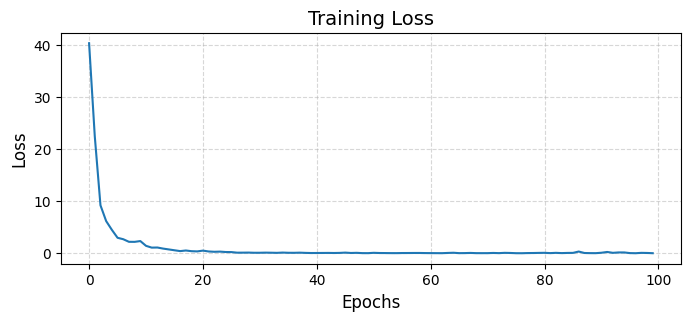

In [12]:
plt.figure(figsize=(8, 3))   
plt.plot(train_losses)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [13]:
k = 5
y0 = 1
sol = odeint(ode, y0, t, args=(k,))
s_t = sol
u_t = -k * sol

s_t_tens = torch.tensor(s_t, dtype=torch.float32).T
t_test = torch.tensor(t, dtype=torch.float32).unsqueeze(1)
print(s_t_tens.shape, t_test.shape)

model.eval()
p = model(s_t_tens, t_test)
p = p.detach().numpy()
print(p.shape)

torch.Size([1, 80]) torch.Size([80, 1])
(80, 1)


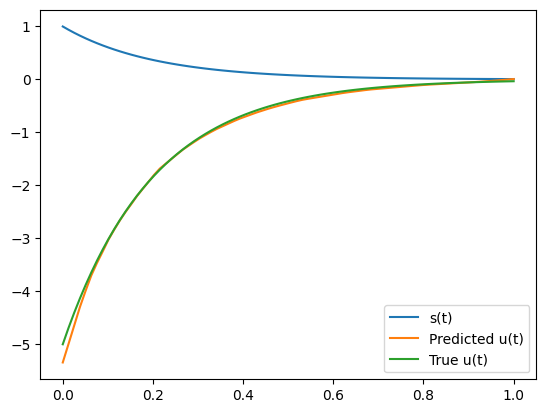

In [15]:
plt.plot(t, s_t, label='s(t)')
plt.plot(t, p, label='Predicted u(t)')
plt.plot(t, u_t, label='True u(t)')
plt.legend()
plt.show()